# Proyek Analisis Data: Kualitas Udara dari Stasiun Gucheng
- **Nama:** Herdiansyah Suhendar
- **Email:** herdiflander@gmail.com
- **ID Dicoding:** herdiansyah_3ia17

## Menentukan Pertanyaan Bisnis

1.   Bagaimana tingkat PM10 bervariasi sepanjang tahun?
2.   Apa hubungan antara tingkat PM10 dengan berbagai kondisi cuaca?



## Import Semua Packages/Library yang Digunakan

In [30]:
import numpy as np # aljabar linear
import pandas as pd # untuk data processing, CSV file I/O (e.g. pd.read_csv)

import statsmodels.api as sm
from scipy.stats import f_oneway

# mengimport visualisasi libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set style untuk seaborn
sns.set_style("whitegrid")

In [31]:
# Menghubungkan collab dengan google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Wrangling

## Gathering Data

In [32]:
# Direktori berisi file CSV
file_path = '/content/drive/MyDrive/data/PRSA_Data_Gucheng_20130301-20170228.csv'
df = pd.read_csv(file_path)

## Assessing Data

In [33]:
initial_assessment = df.head()
initial_columns = df.columns
initial_datatypes = df.dtypes



initial_assessment, initial_columns, initial_datatypes

(   No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
 0   1  2013      3    1     0    6.0  18.0  5.0  NaN  800.0  88.0   0.1   
 1   2  2013      3    1     1    6.0  15.0  5.0  NaN  800.0  88.0  -0.3   
 2   3  2013      3    1     2    5.0  18.0  NaN  NaN  700.0  52.0  -0.7   
 3   4  2013      3    1     3    6.0  20.0  6.0  NaN    NaN   NaN  -1.0   
 4   5  2013      3    1     4    5.0  17.0  5.0  NaN  600.0  73.0  -1.3   
 
      PRES  DEWP  RAIN   wd  WSPM  station  
 0  1021.1 -18.6   0.0   NW   4.4  Gucheng  
 1  1021.5 -19.0   0.0   NW   4.0  Gucheng  
 2  1021.5 -19.8   0.0  WNW   4.6  Gucheng  
 3  1022.7 -21.2   0.0    W   2.8  Gucheng  
 4  1023.0 -21.4   0.0  WNW   3.6  Gucheng  ,
 Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
        'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
       dtype='object'),
 No           int64
 year         int64
 month        int64
 day          int64
 hour       

## Cleaning Data

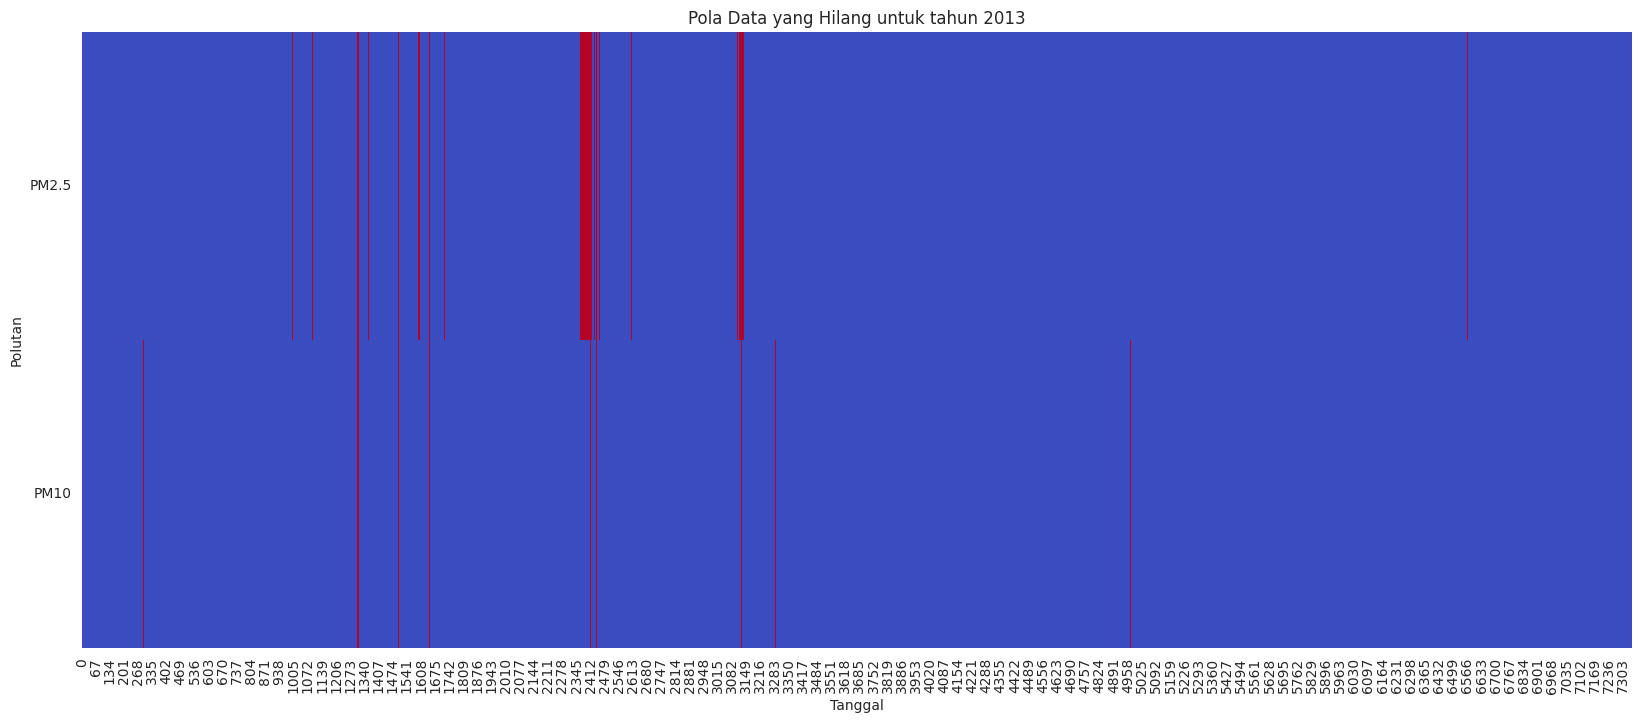

(No         0.000000
 year       0.000000
 month      0.000000
 day        0.000000
 hour       0.000000
 PM2.5      1.842345
 PM10       1.086585
 SO2        1.445927
 NO2        1.905088
 CO         3.995551
 O3         2.079055
 TEMP       0.145448
 PRES       0.142596
 DEWP       0.145448
 RAIN       0.122633
 wd         0.453457
 WSPM       0.119781
 station    0.000000
 dtype: float64,
 PM2.5         136
 PM10           41
 year     14783472
 dtype: int64)

In [36]:
missing_percentage = df.isnull().mean() * 100
cols_to_plot = ['PM2.5', 'PM10']
data_missing = df[cols_to_plot].isnull()
data_missing['year'] = df['year']
data_missing_2013 = data_missing[data_missing['year'] == 2013]
plt.figure(figsize=(20, 8))
sns.heatmap(data_missing_2013.drop('year', axis=1).T, cmap='coolwarm', cbar=False)
plt.title('Pola Data yang Hilang untuk tahun 2013')
plt.xlabel('Tanggal')
plt.ylabel('Polutan')
plt.yticks(rotation=0)
plt.show()

missing_percentage, data_missing_2013.sum()

### Missing Data

*   Terdapat persentase data yang hilang yang relatif kecil untuk polutan, dengan PM2.5 memiliki sekitar 1,84% data yang hilang, dan PM10 memiliki sekitar 1,08% data yang hilang. Polutan dan variabel cuaca lainnya juga memiliki persentase data yang hilang dalam jumlah kecil, yang menunjukkan bahwa dataset ini relatif lengkap
*   Heatmap untuk tahun 2013 menunjukkan bahwa data yang hilang untuk PM2.5 dan PM10 tidak mengikuti pola yang jelas, yang menunjukkan bahwa data yang hilang tersebut mungkin bersifat acak atau tidak sistematis. Tidak ada data yang hilang dalam jangka waktu yang lama, yang merupakan pertanda baik untuk analisis jangka waktu





In [14]:
data_imputed = df.fillna(method='ffill')

duplicates = data_imputed.duplicated().sum()

constant_columns = data_imputed.columns[data_imputed.nunique() <= 1]

data_types = data_imputed.dtypes

duplicates, constant_columns, data_types

(0,
 Index(['station'], dtype='object'),
 No           int64
 year         int64
 month        int64
 day          int64
 hour         int64
 PM2.5      float64
 PM10       float64
 SO2        float64
 NO2        float64
 CO         float64
 O3         float64
 TEMP       float64
 PRES       float64
 DEWP       float64
 RAIN       float64
 wd          object
 WSPM       float64
 station     object
 dtype: object)

### Cleaned Data


*   Meneruskan imputasi pengisian untuk nilai yang hilang.
*   Memeriksa dan tidak menemukan baris duplikat.
*   Mencatat kolom 'stasiun' sebagai konstanta.



# Exploratory Data Analysis (EDA)

- Membuat ringkasan statistik.
- Menganalisis tren jangka waktu dalam tingkat PM10.
- Melakukan uji ANOVA satu arah untuk mengetahui perbedaan tahunan dalam tingkat PM10.
- Menyelidiki tren musiman dan korelasi dengan kondisi cuaca.

In [15]:
summary_statistics = data_imputed.describe()
summary_statistics

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35044.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,84.345203,119.329007,16.020082,55.823144,1352.701945,58.702564,13.855687,1008.835838,2.600456,0.064374,1.343409
std,10122.249256,1.177213,3.448752,8.800218,6.922285,83.228885,97.650791,27.031552,36.535371,1236.264470,58.243262,11.295553,10.104802,13.789758,0.838142,1.150965
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,2.000000,100.000000,0.214200,-15.600000,984.000000,-34.600000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,24.000000,45.000000,2.000000,26.000000,600.000000,10.000000,3.600000,1000.500000,-9.000000,0.000000,0.600000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,60.000000,100.000000,7.000000,50.000000,900.000000,45.000000,14.800000,1008.500000,3.000000,0.000000,1.000000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,116.000000,167.000000,20.000000,79.000000,1700.000000,84.000000,23.500000,1017.000000,15.300000,0.000000,1.800000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,770.000000,994.000000,500.000000,276.000000,10000.000000,450.000000,41.600000,1038.100000,27.400000,41.900000,12.000000


## Visualization & Explanatory Analysis

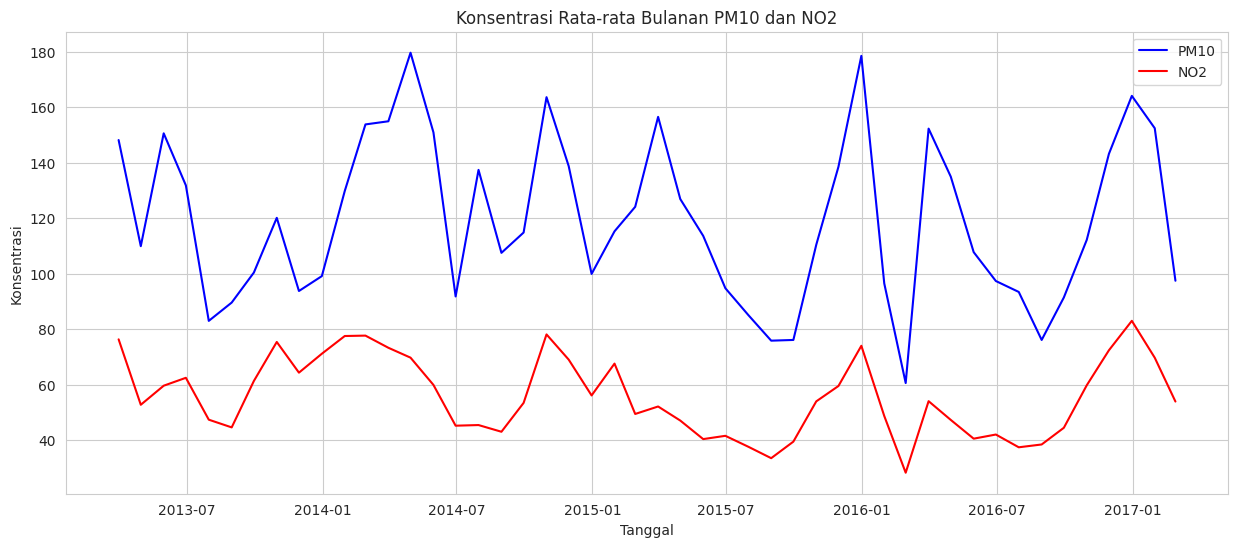

In [26]:
data_imputed['date'] = pd.to_datetime(data_imputed[['year', 'month', 'day', 'hour']])
data_time_series = data_imputed[['date', 'PM10', 'NO2']].set_index('date').resample('M').mean()

plt.figure(figsize=(15, 6))
plt.plot(data_time_series.index, data_time_series['PM10'], label='PM10', color='blue')
plt.plot(data_time_series.index, data_time_series['NO2'], label='NO2', color='red')
plt.title('Konsentrasi Rata-rata Bulanan PM10 dan NO2')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi')
plt.legend()
plt.show()

In [29]:
correlation_matrix = data_imputed[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].corr()
correlation_matrix

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000000,0.847759,0.358211,0.689388,0.739609,-0.172748,-0.145520,0.022633,0.097221,-0.019441,-0.250895
PM10,0.847759,1.000000,0.343362,0.672951,0.607293,-0.123063,-0.058475,-0.063142,0.093864,-0.031578,-0.190281
SO2,0.358211,0.343362,1.000000,0.413636,0.437904,-0.177352,-0.301237,0.184734,-0.269805,-0.035885,-0.080129
NO2,0.689388,0.672951,0.413636,1.000000,0.693491,-0.497497,-0.257629,0.105298,0.005668,-0.046297,-0.423584
CO,0.739609,0.607293,0.437904,0.693491,1.000000,-0.357115,-0.412707,0.249326,-0.160139,-0.022574,-0.256028
O3,-0.172748,-0.123063,-0.177352,-0.497497,-0.357115,1.000000,0.611700,-0.454401,0.340814,0.023027,0.256438
TEMP,-0.145520,-0.058475,-0.301237,-0.257629,-0.412707,0.611700,1.000000,-0.832473,0.821688,0.035968,-0.045914
PRES,0.022633,-0.063142,0.184734,0.105298,0.249326,-0.454401,-0.832473,1.000000,-0.773312,-0.059143,0.129873
DEWP,0.097221,0.093864,-0.269805,0.005668,-0.160139,0.340814,0.821688,-0.773312,1.000000,0.084480,-0.363970
RAIN,-0.019441,-0.031578,-0.035885,-0.046297,-0.022574,0.023027,0.035968,-0.059143,0.084480,1.000000,0.017318


### Summary Statistics

Statistik deskriptif sebelumnya memberikan gambaran umum tentang kecenderungan sentral dan penyebaran untuk setiap variabel, termasuk polutan udara dan data meteorologi. Sebagai contoh, PM10 memiliki nilai rata-rata sekitar 119,33 dengan standar deviasi 97,65, yang mengindikasikan adanya variabilitas yang signifikan dalam konsentrasi polutan ini.

### Tren Jangka Waktu

Plot ini menunjukkan konsentrasi rata-rata bulanan PM10 dan NO2 dari waktu ke waktu. Visualisasi ini membantu dalam mengidentifikasi pola musiman atau perubahan kualitas udara dari tahun ke tahun.

### Analisis Korelasi

*   Relasi Polutan: Matriks korelasi menunjukkan hubungan antara polutan yang berbeda dengan data meteorologi. Sebagai contoh, terdapat korelasi positif yang kuat antara PM10 dan NO2, yang menunjukkan kemungkinan adanya sumber yang sama atau interaksi di antara polutan-polutan ini.
*   Cuaca dan Polutan: Terdapat korelasi yang menarik antara kondisi cuaca dan polutan, seperti korelasi negatif antara O3 dan suhu, dan antara O3 dan tekanan atmosfer.



Hasil Uji ANOVA: F_onewayResult(statistic=86.48427258660752, pvalue=3.0558915250133905e-73)
Seasonal Trends: month
1     123.481418
2     108.543142
3     152.966835
4     137.846875
5     130.712164
6     103.915972
7      99.714046
8      87.246505
9      95.673854
10    126.578293
11    128.549167
12    135.397513
Name: PM10, dtype: float64
Korelasi dengan Kondisi Cuaca: TEMP   -0.057146
PRES   -0.065550
DEWP    0.097019
RAIN   -0.032246
PM10    1.000000
Name: PM10, dtype: float64


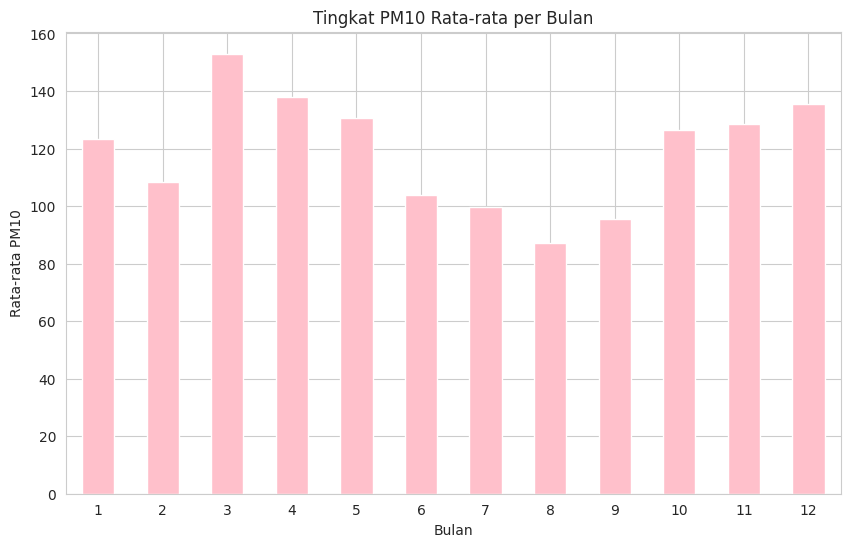

In [28]:
data_imputed.fillna(method='ffill', inplace=True)


groups = data_imputed.groupby('year')['PM10']

anova_test_data = [group[1] for group in groups]

anova_test_result = f_oneway(*anova_test_data)


seasonal_trends = data_imputed.groupby('month')['PM10'].mean()

weather_correlations = df[['TEMP', 'PRES', 'DEWP', 'RAIN', 'PM10']].corr()['PM10']


print("Hasil Uji ANOVA:", anova_test_result)
print("Seasonal Trends:", seasonal_trends)
print("Korelasi dengan Kondisi Cuaca:", weather_correlations)

plt.figure(figsize=(10, 6))
seasonal_trends.plot(kind='bar', color='pink')
plt.title('Tingkat PM10 Rata-rata per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata PM10')
plt.xticks(ticks=range(0, 12), labels=[str(m) for m in range(1, 13)], rotation=0)
plt.show()

### Pengujian Hipotesis (ANOVA)

Dari hasil Uji ANOVA, dapat dilihat bahwa nilai p-value sangat kecil (3.0558915250133905e-73), yang menunjukkan bahwa terdapat perbedaan yang signifikan secara statistik pada tingkat PM10 di tahun-tahun yang berbeda. Artinya, kita dapat menolak hipotesis nol (H0) bahwa rata-rata tingkat PM10 sama setiap tahunnya.

### Seasonal Trends

Grafik batang menunjukkan nilai PM10 rata-rata bulanan dan variasi musiman.Konsentrasi yang lebih tinggi diamati pada bulan-bulan  awal dan akhir musim dingin (puncaknya pada bulan Maret, April, dan kemudian Desember), dan konsentrasi yang lebih rendah pada bulan-bulan musim panas (Agustus, September).

### Korelasi dengan Kondisi Cuaca

Korelasi antara PM10 dan kondisi cuaca menunjukkan:

*   Korelasi negatif dengan suhu (TEMP), yang menunjukkan korelasi antara PM10 dan TEMP adalah -0.057146, yang menunjukkan hubungan korelasi negatif yang lemah antara konsentrasi PM10 dan suhu.
*   Korelasi positif dengan titik embun (DEWP), yang mengindikasikan tingkat PM10 yang lebih tinggi dapat berhubungan dengan kelembaban yang lebih tinggi.
*   Korelasi antara PM10 dan tekanan atmosfer (PRES) adalah -0.065550, yang menunjukkan hubungan korelasi negatif yang lemah antara konsentrasi PM10 dan tekanan atmosfer.
*   Korelasi antara PM10 dan RAIN adalah -0.032246, yang menunjukkan hubungan korelasi negatif yang sangat lemah antara konsentrasi PM10 dan curah hujan










# Conclusion

- Bagaimana tingkat PM10 bervariasi sepanjang tahun ?

Jawab : Ditemukan variasi musiman yang signifikan pada tingkat PM10, dengan konsentrasi yang lebih tinggi pada bulan-bulan yang lebih dingin, yang mengindikasikan kemungkinan pengaruh dari kondisi kelembapannya



- Apa hubungan antara tingkat PM10 dengan berbagai kondisi cuaca ?

Jawab : Terlihat adanya korelasi negatif yang lemah antara tingkat PM10 dan suhu, yang menunjukkan jika cuaca nya lebih dingin dapat meningkatkan polusi. Korelasi minimal dengan curah hujan dan tekanan atmosfer juga ditemukan disini.